# 0. Create the Environment

In [1]:
# create environment:
# terminal:
#conda create -n tmdb --file requirements.txt
#pip install ipykernel
#python -m ipykernel install --user --name=tmdb
#jupyter notebook => Kernel -> Change Kernel -> tmdb

# 1. Define the problem

The aim of this project is to try to predict whether or not films will be highly rated. To see if films will be a commercial success or not. For that, the dataset provided gives the plot, cast, crew, budget, revenues and much more information about several thousand films.

# 2. Import libraries

In [2]:
import sys
import subprocess

In [3]:
import os
os.environ['TOKENIZERS_PARALELISM'] = "true"

# data manipulation
import json
import pandas as pd

# data visualization
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from plotly import graph_objects as go

# nlp utils
import ast
import contractions
from collections import Counter
from wordcloud import WordCloud, STOPWORDS as wc_STOPWORDS

# Bert sentence-transformer embedding
from sentence_transformers import SentenceTransformer

# xgb regression-model
import xgboost

# model selection
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae


## 2.1 Add packages to the requirements.

In [4]:
import types
import pkg_resources
from req_utils import get_imports

#### Create requirements.txt file

In [5]:
reqs = open("requirements.txt", "w")
imports = list(set(get_imports(globals().items())))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r), file=reqs)
reqs.close()

# 3. Load the datasets

In [6]:
credits = pd.read_csv('data/tmdb_5000_credits.csv')
movies = pd.read_csv('data/tmdb_5000_movies.csv')

# 4. Exploratory Data Anslysis (EDA)

#### Check dataset dimensions

In [7]:
credits.shape, movies.shape

((4803, 4), (4803, 20))

We can see that the `credits` dataset has $4$ variables and $4803$ instances. The `movies` dataset has $20$ variables and the same amount of instances as `credits`.

#### Preview the datasets

In [8]:
# see how do credits and movies look like
credits.head(2)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


The first thing we can see is that both `cast` and `crew`have lists of json files, which might make the datset difficult to work with. So the first step is going to be to convert it to different new columns so as to hae propper data.

In [9]:
movies.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [10]:
movies.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

The same goes for the movies dataset, `genres`, `keywords`, `production_companies`, `production_countries` and `spoken languages` have all a list of json files.

In [11]:
def get_names_from_json(df, col, json_key='name'):
    for index, data in zip(df.index, df[col]):
        l = []  # create list to input the names of the genres.
        for j in range(len(data)):
            l.append((data[j][json_key]))  # access the name of the genre
        df.loc[index, col] = str(l)
    return df

In [12]:
# get the name of each json: the shape of the json is:{id, name}, ...,{} for all jsons
movies_json_cols = ['genres', 'keywords', 'production_companies', 'production_countries', 'spoken_languages']
for col in movies_json_cols:
    movies[col] = movies[col].apply(json.loads)

In [13]:
# apply conversion, so as to have list of names for each json column
for col in movies_json_cols:
    movies = get_names_from_json(movies, col)

In [14]:
movies.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"['Action', 'Adventure', 'Fantasy', 'Science Fi...",http://www.avatarmovie.com/,19995,"['culture clash', 'future', 'space war', 'spac...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"['Ingenious Film Partners', 'Twentieth Century...","['United States of America', 'United Kingdom']",2009-12-10,2787965087,162.0,"['English', 'Español']",Released,Enter the World of Pandora.,Avatar,7.2,11800


We can also apply this to the case of the credits dataset

In [15]:
# we are interested in the name of the cast
credits['cast'] = credits['cast'].apply(json.loads)
credits = get_names_from_json(credits, 'cast')

In [16]:
# in the case of the crew, we are interested in the and the name of the director of the film

In [17]:
credits['crew'] = credits['crew'].apply(json.loads)

def get_director(x):
    for i in x:
        if i['job'].lower() == 'director':
            return i["name"]

credits['crew'] = credits['crew'].apply(get_director)

In [18]:
credits.head(1)

,movie_id,title,cast,crew
0,19995,Avatar,"['Sam Worthington', 'Zoe Saldana', 'Sigourney ...",James Cameron


We now have both the `credits` and `movies` datasets without any json file in a row, so we can start a further data exploration on our datasets.

### Get info of the datasets

In [19]:
credits.info(), movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  4803 non-null   int64 
 1   title     4803 non-null   object
 2   cast      4803 non-null   object
 3   crew      4773 non-null   object
dtypes: int64(1), object(3)
memory usage: 150.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   objec

(None, None)

We can see there are both `object` and `int64` data types, so we will have to deal with them separately.

In [20]:
credits.isna().values.any(), movies.isna().values.any()

(True, True)

We can see there are nans in both datasets, lets take a further look at them. First of all, we can join the two datasets into one thanks to the `id` column from the `movies` dataset and the `movie_id` column in the `credits` dataset.

#### Merge the two datasets into one by the movie id

In [21]:
df = movies.merge(credits, left_on='id', right_on='movie_id', how='left')

In [22]:
# check the columns the new dataframe has:
df.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title_x', 'vote_average',
       'vote_count', 'movie_id', 'title_y', 'cast', 'crew'],
      dtype='object')

We can see that it has generated a `title_x` and a `title_y` as well as kept `id` and `movie_id`, lets see if they are equal. If they are, we can drop one of them.

In [23]:
df['title_x'].equals(df['title_y']), df['id'].equals(df['movie_id'])

(True, True)

They are in fact equal, so we can drop one title column and one id column

In [24]:
# drop title_y and movie_id
df.drop('title_y', axis=1, inplace=True)
df.drop('movie_id', axis=1, inplace=True)

# rename title_x to title
df.rename(columns={'title_x': 'title'}, inplace=True, errors='raise')

In [25]:
df.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'cast', 'crew'],
      dtype='object')

#### Deal with dates creating 3 columns: year-month-day 

By doing this, our model will be able to learn from three new features instead of the original object-type column `release_date`.

In [26]:
df['release_year'] = pd.to_datetime(df['release_date']).dt.year.astype('Int64')
df['release_month'] = pd.to_datetime(df['release_date']).dt.month.astype('Int64')
df['release_day'] = pd.to_datetime(df['release_date']).dt.day.astype('Int64')

# finally drop release_date column
df.drop('release_date', axis=1, inplace=True)

### Check missing values

In [27]:
df.isna().values.any()

True

We can see there are NaNs, we can see this graphically by using `missingno`

<AxesSubplot:>

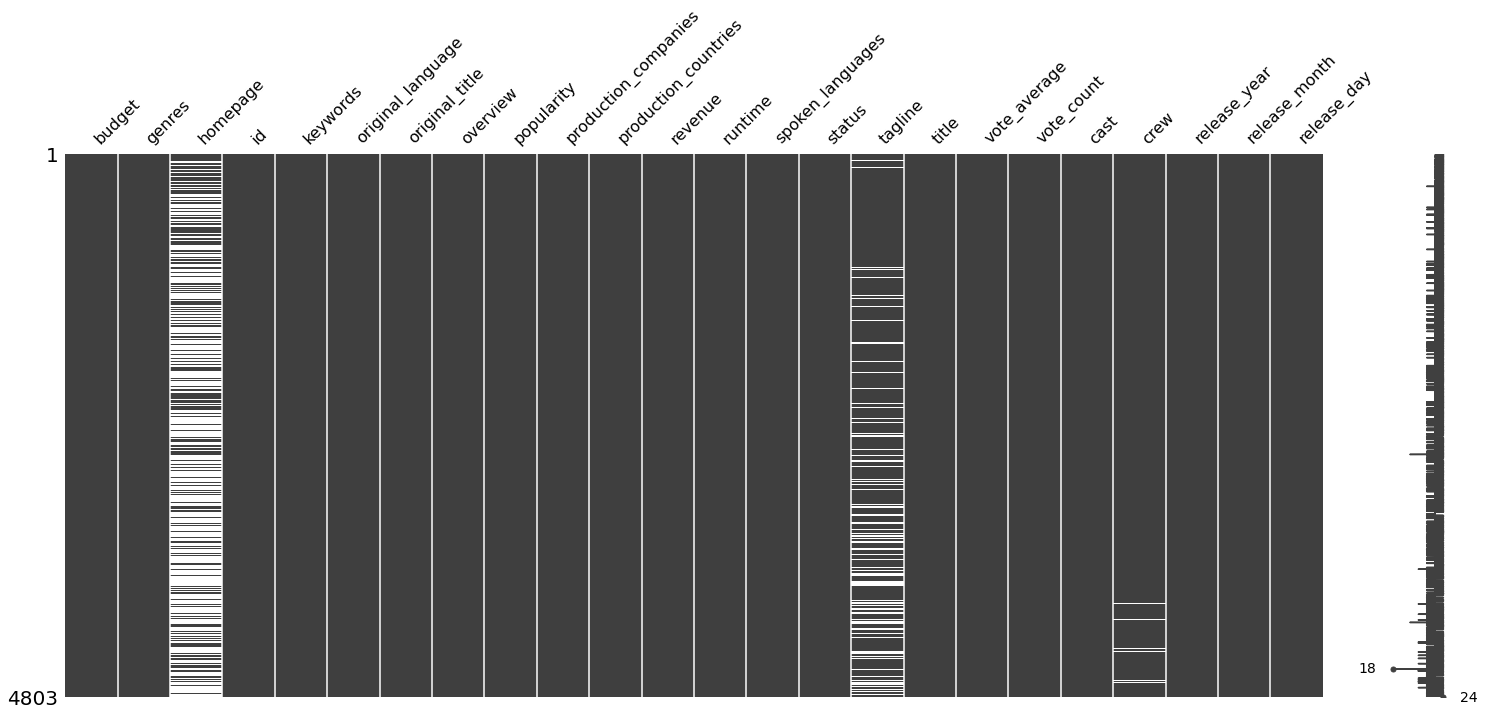

In [28]:
msno.matrix(df)

We can now easily see that the columns with the most NaNs are `hommepage` and `tagline`, let's see what they look like and see if they are worth keeping or not.

In [29]:
df['homepage'][0]

'http://www.avatarmovie.com/'

In [30]:
round(df['homepage'].isna().sum() / len(df), 2)

0.64

It redirects to the website of the movies and has a $64\%$ of nans. However, the information we could get is already part of the dataframe in `title` and `production_companies`. We can comfortably remove this column.

In [31]:
# drop homepage column
df.drop('homepage', axis=1, inplace=True)

In [32]:
round(df['tagline'].isna().sum() / len(df), 2)

0.18

Around $18\%$ of the `tagline` values are missing are cannot be interpolated from the rest of rows in the column. We will drop this column since the information can be pretty much inferred from the `genre` column. When doing feature engineering, however, we will check how the model performs with and without this variable.

In [33]:
# drop tagline
df.drop('tagline', axis=1, inplace=True)

### Imputing rows of columns with small number of missing values

In [34]:
df.isna().sum()

budget                   0
genres                   0
id                       0
keywords                 0
original_language        0
original_title           0
overview                 3
popularity               0
production_companies     0
production_countries     0
revenue                  0
runtime                  2
spoken_languages         0
status                   0
title                    0
vote_average             0
vote_count               0
cast                     0
crew                    30
release_year             1
release_month            1
release_day              1
dtype: int64

The number of nans is very small, so we can remove those rows to make it easier for our model to learn.

In [35]:
df.dropna(inplace=True)

In [36]:
df.isna().values.any()

False

We finally have a clean daaset, we can move on to the next step.

The dataset not looks like:

In [37]:
# enable to see how each column looks like
pd.set_option('display.max_columns', None)
df.head(5)

,budget,genres,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,revenue,runtime,spoken_languages,status,title,vote_average,vote_count,cast,crew,release_year,release_month,release_day
0,237000000,"['Action', 'Adventure', 'Fantasy', 'Science Fi...",19995,"['culture clash', 'future', 'space war', 'spac...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"['Ingenious Film Partners', 'Twentieth Century...","['United States of America', 'United Kingdom']",2787965087,162.0,"['English', 'Español']",Released,Avatar,7.2,11800,"['Sam Worthington', 'Zoe Saldana', 'Sigourney ...",James Cameron,2009,12,10
1,300000000,"['Adventure', 'Fantasy', 'Action']",285,"['ocean', 'drug abuse', 'exotic island', 'east...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"['Walt Disney Pictures', 'Jerry Bruckheimer Fi...",['United States of America'],961000000,169.0,['English'],Released,Pirates of the Caribbean: At World's End,6.9,4500,"['Johnny Depp', 'Orlando Bloom', 'Keira Knight...",Gore Verbinski,2007,5,19
2,245000000,"['Action', 'Adventure', 'Crime']",206647,"['spy', 'based on novel', 'secret agent', 'seq...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"['Columbia Pictures', 'Danjaq', 'B24']","['United Kingdom', 'United States of America']",880674609,148.0,"['Français', 'English', 'Español', 'Italiano',...",Released,Spectre,6.3,4466,"['Daniel Craig', 'Christoph Waltz', 'Léa Seydo...",Sam Mendes,2015,10,26
3,250000000,"['Action', 'Crime', 'Drama', 'Thriller']",49026,"['dc comics', 'crime fighter', 'terrorist', 's...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"['Legendary Pictures', 'Warner Bros.', 'DC Ent...",['United States of America'],1084939099,165.0,['English'],Released,The Dark Knight Rises,7.6,9106,"['Christian Bale', 'Michael Caine', 'Gary Oldm...",Christopher Nolan,2012,7,16
4,260000000,"['Action', 'Adventure', 'Science Fiction']",49529,"['based on novel', 'mars', 'medallion', 'space...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,['Walt Disney Pictures'],['United States of America'],284139100,132.0,['English'],Released,John Carter,6.1,2124,"['Taylor Kitsch', 'Lynn Collins', 'Samantha Mo...",Andrew Stanton,2012,3,7


In order to perform further feature engineering and exploratory data analysis, we will remove the lists of the `genres`, `keywords`, `production_companies`, `production_countries`, `spoken_languages` and `cast`.

In [38]:
df['genres'] = df['genres'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.split(',')

In [39]:
# create a simple dataframe of all the genres (split lists into columns)
a = df['genres'].apply(pd.Series)

In [40]:
# get set of unique genres:
genres = []
for x in range(len(a.columns)):
    gen = a[x].unique()
    for g in gen:
        if g not in genres:
            genres.append(g)

# pop nan and ''.
genres.pop(); genres.remove('')

In [41]:
def build_boolean_df(items, unique_items):
    bool_dict = {}    
    
    for i, item in enumerate(unique_items):
        # Apply boolean mask
        bool_dict[item] = items.apply(lambda x: item in x)
    
    return pd.DataFrame(bool_dict)

In [42]:
df[genres] = build_boolean_df(df['genres'], genres) * 1

We now have a boolean of each genre in our dataframe, we can thus remove the `genres` column.

In [43]:
# df.drop('genres', axis=1, inplace=True)

The dataframe columns now look like:

In [44]:
df.head(1)

,budget,genres,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,revenue,runtime,spoken_languages,status,title,vote_average,vote_count,cast,crew,release_year,release_month,release_day,Action,Adventure,Fantasy,Animation,ScienceFiction,Drama,Thriller,Family,Comedy,History,War,Western,Romance,Crime,Mystery,Horror,Documentary,Music,TVMovie,Foreign
0,237000000,"[Action, Adventure, Fantasy, ScienceFiction]",19995,"['culture clash', 'future', 'space war', 'spac...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"['Ingenious Film Partners', 'Twentieth Century...","['United States of America', 'United Kingdom']",2787965087,162.0,"['English', 'Español']",Released,Avatar,7.2,11800,"['Sam Worthington', 'Zoe Saldana', 'Sigourney ...",James Cameron,2009,12,10,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Plot correlation between genres

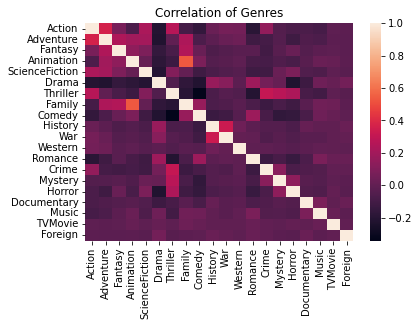

In [45]:
sns.heatmap(df[genres].corr(method="pearson"), annot=False);
plt.title("Correlation of Genres");

In [46]:
# TODO: add the rest of written information to overview (lowercase and stemming).

In [47]:
df['original_title'].equals(df['title'])

False

The next step is going to be to build a "soup" with all the text data in the columns. This way, it will be more conveninent for a model to learn later.

In [48]:
text_cols = list(df.select_dtypes(['object']).columns)

In [49]:
df[text_cols].head(1)

,genres,keywords,original_language,original_title,overview,production_companies,production_countries,spoken_languages,status,title,cast,crew
0,"[Action, Adventure, Fantasy, ScienceFiction]","['culture clash', 'future', 'space war', 'spac...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...","['Ingenious Film Partners', 'Twentieth Century...","['United States of America', 'United Kingdom']","['English', 'Español']",Released,Avatar,"['Sam Worthington', 'Zoe Saldana', 'Sigourney ...",James Cameron


In [50]:
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i) for i in x]
    else:
        if isinstance(x, str):
            return str.lower(x)
        else:
            return ""

In [51]:
for feature in text_cols:
    df[feature] = df[feature].apply(clean_data)

In [52]:
df[text_cols].head(1)

,genres,keywords,original_language,original_title,overview,production_companies,production_countries,spoken_languages,status,title,cast,crew
0,"[action, adventure, fantasy, sciencefiction]","['culture clash', 'future', 'space war', 'spac...",en,avatar,"in the 22nd century, a paraplegic marine is di...","['ingenious film partners', 'twentieth century...","['united states of america', 'united kingdom']","['english', 'español']",released,avatar,"['sam worthington', 'zoe saldana', 'sigourney ...",james cameron


In [53]:
def create_soup(x):
    return x['overview'] \
    + " ".join(x['genres']) \
    + " " + "". join(x['keywords'])  \
    + " " + x['original_title'] \
    + " " + "". join(x['production_companies']) \
    + " " + x['original_language'] \
    + " " + "". join(x['production_countries']) \
    + " " + "". join(x['spoken_languages']) \
    + " " + x['status'] \
    + " " + x['title'] \
    + " " + "". join(x['cast']) \
    + " " + x['crew']

In [54]:
df['soup'] = df.apply(create_soup, axis=1)

In [55]:
import re
def clean_text(x):
    return re.sub(r'\W+', ' ', x['soup'])

In [56]:
df['soup'] = df.apply(clean_text, axis=1)

### Create dataset with the soup and numeric columns

In [57]:
df['soup'][0]

'in the 22nd century a paraplegic marine is dispatched to the moon pandora on a unique mission but becomes torn between following orders and protecting an alien civilization action adventure fantasy sciencefiction culture clash future space war space colony society space travel futuristic romance space alien tribe alien planet cgi marine soldier battle love affair anti war power relations mind and soul 3d avatar ingenious film partners twentieth century fox film corporation dune entertainment lightstorm entertainment en united states of america united kingdom english español released avatar sam worthington zoe saldana sigourney weaver stephen lang michelle rodriguez giovanni ribisi joel david moore cch pounder wes studi laz alonso dileep rao matt gerald sean anthony moran jason whyte scott lawrence kelly kilgour james patrick pitt sean patrick murphy peter dillon kevin dorman kelson henderson david van horn jacob tomuri michael blain rozgay jon curry luke hawker woody schultz peter men

In [58]:
new_df_cols = [x for x in df.columns if x not in genres + text_cols]

In [59]:
new_df = df[new_df_cols]

### Visualize WordCloud

We now have the soup of text information in the `soup` column. We can now visualize the most common words.

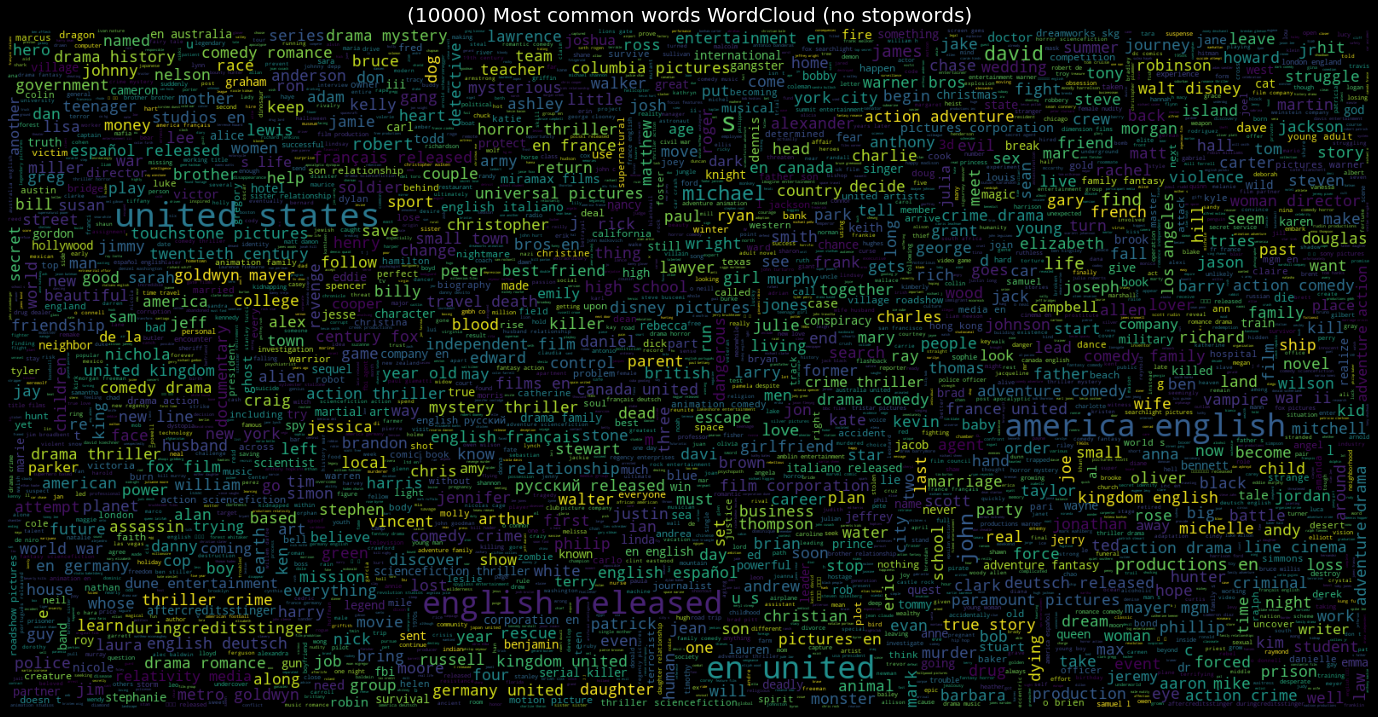

In [60]:
wc = WordCloud(background_color="black", max_words=10000, 
               stopwords=wc_STOPWORDS, max_font_size=40,
               width=1600, height=800
               )
wc.generate(" ".join(new_df['soup'].values))
plt.figure(figsize=(20, 10), facecolor='k')
plt.title("(10000) Most common words WordCloud (no stopwords)", fontsize=20, color='w')
plt.imshow(wc)
plt.tight_layout(pad=0)
plt.axis('off')
# save the image
plt.savefig('images/10000-wordcloud_20x10.png', facecolor='k', bbox_inches='tight');
plt.show()

In [61]:
new_df['soup']

0       in the 22nd century a paraplegic marine is dis...
1       captain barbossa long believed to be dead has ...
2       a cryptic message from bond s past sends him o...
3       following the death of district attorney harve...
4       john carter is a war weary former military cap...
                              ...                        
4798    el mariachi just wants to play his guitar and ...
4799    a newlywed couple s honeymoon is upended by th...
4800     signed sealed delivered introduces a dedicate...
4801    when ambitious new york attorney sam is sent t...
4802    ever since the second grade when he first saw ...
Name: soup, Length: 4770, dtype: object

In [62]:
# load the bert sentence transformer model
bert_model = SentenceTransformer('bert-base-nli-max-tokens')

In [63]:
soups = ["".join(soup) for soup in new_df['soup']]

In [64]:
import numpy as np
bert_embedding = np.array(
    bert_model.encode(soups, 
                      show_progress_bar=True)
)

Batches:   0%|          | 0/150 [00:00<?, ?it/s]

In [65]:
bert_embedding.shape, new_df.shape

((4770, 768), (4770, 11))

In [66]:
from sklearn.metrics.pairwise import cosine_similarity

In [67]:
similarity = cosine_similarity(bert_embedding)

In [68]:
similarity

array([[1.0000001 , 0.8948524 , 0.8562901 , ..., 0.82656914, 0.7907827 ,
        0.87249655],
       [0.8948524 , 0.9999999 , 0.89560103, ..., 0.88079166, 0.85146135,
        0.8694948 ],
       [0.8562901 , 0.89560103, 1.0000001 , ..., 0.9104426 , 0.8718066 ,
        0.8581673 ],
       ...,
       [0.82656914, 0.88079166, 0.9104426 , ..., 0.9999997 , 0.91348225,
        0.8629476 ],
       [0.7907827 , 0.85146135, 0.8718066 , ..., 0.91348225, 0.9999998 ,
        0.85001326],
       [0.87249655, 0.8694948 , 0.8581673 , ..., 0.8629476 , 0.85001326,
        0.9999999 ]], dtype=float32)

### Visualize the similarity of all films based just on their text-data

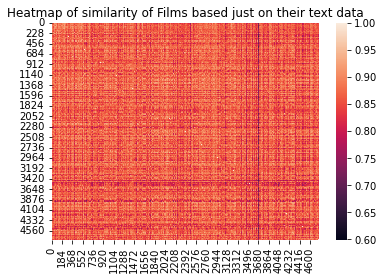

In [69]:
sns.heatmap(similarity, annot=False);
plt.title("Heatmap of similarity of Films based just on their text data");

We can see there isn't that much of a difference between all films, let's see what happens if we select the top 20 films and the lower 20 films by rating and see if there is any similarity betwen them.

In [70]:
top_20 = list(new_df.nlargest(20, 'vote_average').index)
bottom_20 = list(new_df.nsmallest(20, 'vote_average').index)

In [71]:
new_df.loc[top_20].head()

,budget,id,popularity,revenue,runtime,vote_average,vote_count,release_year,release_month,release_day,soup
3519,0,89861,0.356495,0,99.0,10.0,1,1998,6,12,stiff upper lips is a broad parody of british ...
4045,0,78373,0.376662,565592,97.0,10.0,1,1998,5,1,four guys best friends have grown up together ...
3992,0,346081,0.296981,0,0.0,9.5,2,2015,6,26,a ghost hunter uses bottles to capture trouble...
2386,0,69848,0.910529,0,121.0,9.3,2,1999,8,2,one man s hero tells the little known story of...
1881,25000000,278,136.747729,28341469,142.0,8.5,8205,1994,9,23,framed in the 1940s for the double murder of h...


In [72]:
similarity[top_20].shape

(20, 4770)

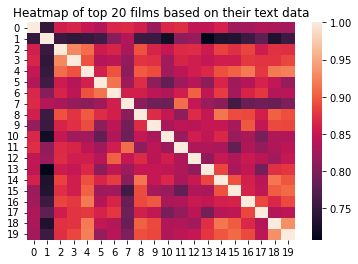

In [73]:
sns.heatmap(cosine_similarity(bert_embedding[top_20]), annot=False);
plt.title("Heatmap of top 20 films based on their text data");

We can see there is a relatively high cosine similarity between the top 20 films if we base their similarity on the text embedding from bert sentence-transformer.

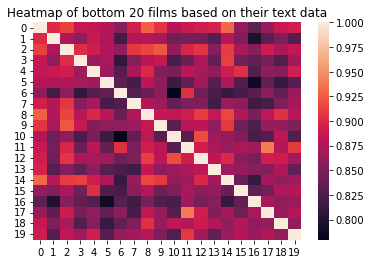

In [74]:
sns.heatmap(cosine_similarity(bert_embedding[bottom_20]), annot=False);
plt.title("Heatmap of bottom 20 films based on their text data");

In he case of the bottom 20, there seems to be more different approaches to achieve a low rating.

In [75]:
top_n_bottom = top_20 + bottom_20

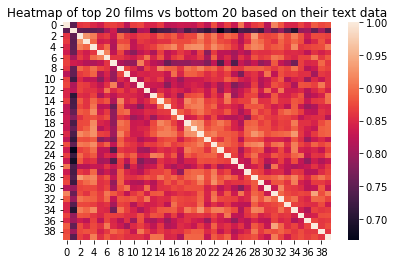

In [76]:
sns.heatmap(cosine_similarity(bert_embedding[top_n_bottom]), annot=False);
plt.title("Heatmap of top 20 films vs bottom 20 based on their text data");

In [77]:
# view how are ratings distributed and correlations between budget, revenue, vote average...

In [78]:
new_df.head(1)

,budget,id,popularity,revenue,runtime,vote_average,vote_count,release_year,release_month,release_day,soup
0,237000000,19995,150.437577,2787965087,162.0,7.2,11800,2009,12,10,in the 22nd century a paraplegic marine is dis...


### Vote Average distribution

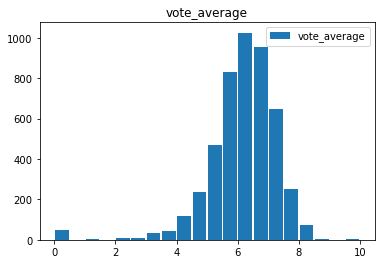

In [79]:
new_df[['vote_average']].hist(grid=False, bins=20, rwidth=0.9, legend=True);

The `voting average` distribution is negatively skewed. Note that there are several films sitting at 0 rating, while most films sit around an average of $6$. Also, it is worth mentioning that very few films get past a vote average of $8$.

In [80]:
hist_cols = new_df[new_df.columns[:-3]].drop('id', axis=1).columns

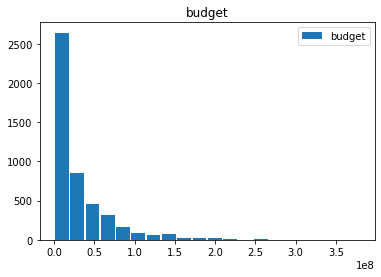

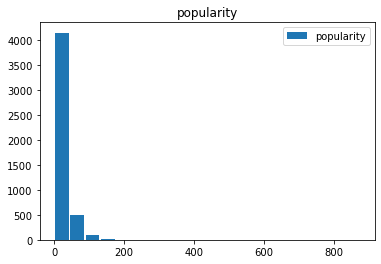

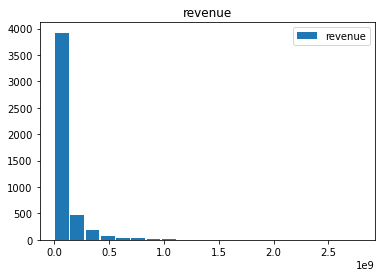

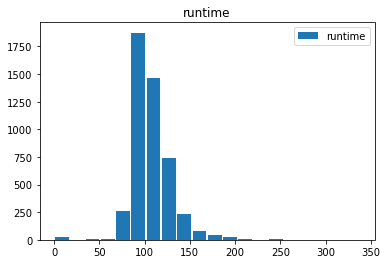

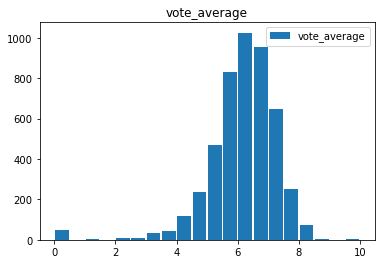

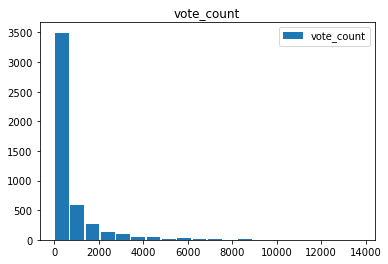

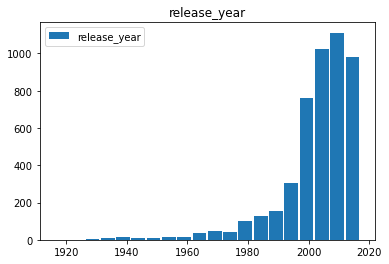

In [81]:
for x in hist_cols:
    new_df[[x]].hist(grid=False, bins=20, rwidth=0.9, legend=True);

Takeaways from the histogram plots:
* Most films have little to no budget.

* The same goes for popularity, very few films have large popularity.

* The revenue also follows the same trend as the previous two plots: negative exponential distribution.

* The runtime is usually concentrated around the $100$ minutes.

* The vote_average, as we mentioned before, is negatively skewed and the median is around $6$

* The vote_count is usually exremely low

* The amount of films from the year $2000$ on have grown almost exponentially.


Let's see how do all variables relate to each other in a correlation plot:

### Numeric variables Correlation plot

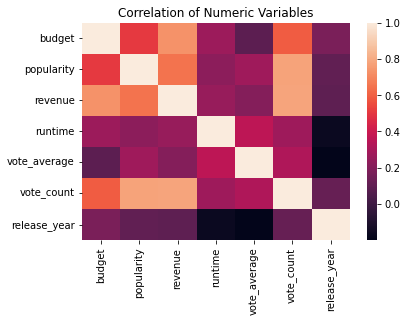

In [82]:
sns.heatmap(new_df[hist_cols].corr(method="pearson"), annot=False);
plt.title("Correlation of Numeric Variables");

There seems to be a strong correlation between `popularity` and `vote_count`. Curiously, there is also a really high correlation between `vote_count`and the revenue.

The `vote_average`, however, is not extremely correlated with any other column. However, it seems to have a correlation with `runtime`, `popularity` and `vote_count`. The correlation with `runtime` after seeing the distribution of the variable might not be as significant as the correlation with the other two. However, we will see later once we build the model.

# 5. Build the Model

### XGBoost with text and numeric data

In [83]:
X = new_df.drop(['soup', 'id', 'vote_average'], axis=1)

In [84]:
X.values.shape, bert_embedding.shape

((4770, 8), (4770, 768))

In [85]:
X_data = np.concatenate((X, bert_embedding), axis=1)
y_data = new_df['vote_average']

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=333)

In [87]:
model = xgboost.XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [88]:
print(model)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)


In [89]:
# make predictions for test data:
y_pred = model.predict(X_test)

In [90]:
mean_sq_error = mse(y_test, y_pred)
mean_abs_error = mae(y_test, y_pred)

In [91]:
print("Mean Squared Error: %.2f" % (mean_sq_error))
print("Mean Absolute Error: %.2f" % (mean_abs_error))

Mean Squared Error: 0.56
Mean Absolute Error: 0.57


### XGBoost without text data

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.2, random_state=333)

In [93]:
model = xgboost.XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [94]:
print(model)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)


In [95]:
# make predictions for test data:
y_pred = model.predict(X_test)

In [96]:
mean_sq_error = mse(y_test, y_pred)
mean_abs_error = mae(y_test, y_pred)

In [97]:
print("Mean Squared Error: %.2f" % (mean_sq_error))
print("Mean Absolute Error: %.2f" % (mean_abs_error))

Mean Squared Error: 0.69
Mean Absolute Error: 0.60


We can clearly see a difference in the error achieved. Text features help with achieving higher accuracy.

### XGBoost only with text data

In [98]:
X_train, X_test, y_train, y_test = train_test_split(bert_embedding, y_data, test_size=0.2, random_state=333)

In [99]:
model = xgboost.XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [100]:
print(model)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)


In [101]:
# make predictions for test data:
y_pred = model.predict(X_test)

In [102]:
mean_sq_error = mse(y_test, y_pred)
mean_abs_error = mae(y_test, y_pred)

In [103]:
print("Mean Squared Error: %.2f" % (mean_sq_error))
print("Mean Absolute Error: %.2f" % (mean_abs_error))

Mean Squared Error: 1.36
Mean Absolute Error: 0.82


Just using the text embedding from bert does not seem to be the best option to predict proper values in the target. Let's see what might happen if we just use One-Hot-Encoding of genres and remove the rest of the text data.

### XGBRegressor with Binary Encoding of genres

In [104]:
X = df.drop(text_cols, axis=1).drop(['id', 'soup', 'vote_average'], axis=1)

In [105]:
X

,budget,popularity,revenue,runtime,vote_count,release_year,release_month,release_day,Action,Adventure,Fantasy,Animation,ScienceFiction,Drama,Thriller,Family,Comedy,History,War,Western,Romance,Crime,Mystery,Horror,Documentary,Music,TVMovie,Foreign
0,237000000,150.437577,2787965087,162.0,11800,2009,12,10,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,300000000,139.082615,961000000,169.0,4500,2007,5,19,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,245000000,107.376788,880674609,148.0,4466,2015,10,26,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,250000000,112.312950,1084939099,165.0,9106,2012,7,16,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,260000000,43.926995,284139100,132.0,2124,2012,3,7,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,220000,14.269792,2040920,81.0,238,1992,9,4,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4799,9000,0.642552,0,85.0,5,2011,12,26,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
4800,0,1.444476,0,120.0,6,2013,10,13,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0
4801,0,0.857008,0,98.0,7,2012,5,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.2, random_state=333)

In [107]:
model = xgboost.XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [108]:
print(model)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)


In [109]:
# make predictions for test data:
y_pred = model.predict(X_test)

In [110]:
mean_sq_error = mse(y_test, y_pred)
mean_abs_error = mae(y_test, y_pred)

In [111]:
print("Mean Squared Error: %.2f" % (mean_sq_error))
print("Mean Absolute Error: %.2f" % (mean_abs_error))

Mean Squared Error: 0.56
Mean Absolute Error: 0.53


The MAE gets lower than with the bert embedding and the MSE performs equal as it did with the bert embedding.

In [112]:
# Plot the feature importances: model.feature_importances_.

### Binary Encoding of genres plus Bert Embedding of text data

In [113]:
X.columns

Index(['budget', 'popularity', 'revenue', 'runtime', 'vote_count',
       'release_year', 'release_month', 'release_day', 'Action', 'Adventure',
       'Fantasy', 'Animation', 'ScienceFiction', 'Drama', 'Thriller', 'Family',
       'Comedy', 'History', 'War', 'Western', 'Romance', 'Crime', 'Mystery',
       'Horror', 'Documentary', 'Music', 'TVMovie', 'Foreign'],
      dtype='object')

In [114]:
X_data = np.concatenate((X, bert_embedding), axis=1)
y_data = new_df['vote_average']

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=333)

In [116]:
model = xgboost.XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [117]:
print(model)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)


In [118]:
# make predictions for test data:
y_pred = model.predict(X_test)

In [119]:
mean_sq_error = mse(y_test, y_pred)
mean_abs_error = mae(y_test, y_pred)

In [120]:
print("Mean Squared Error: %.2f" % (mean_sq_error))
print("Mean Absolute Error: %.2f" % (mean_abs_error))

Mean Squared Error: 0.55
Mean Absolute Error: 0.54


## Ridge Regression Model

In [121]:
from sklearn.linear_model import LassoCV

In [122]:
model = LassoCV(cv=5, random_state=0)
model.fit(X_train, y_train)

LassoCV(cv=5, random_state=0)

In [123]:
print(model)

LassoCV(cv=5, random_state=0)


In [124]:
# make predictions for test data:
y_pred = model.predict(X_test)

In [125]:
mean_sq_error = mse(y_test, y_pred)
mean_abs_error = mae(y_test, y_pred)

In [126]:
print("Mean Squared Error: %.2f" % (mean_sq_error))
print("Mean Absolute Error: %.2f" % (mean_abs_error))

Mean Squared Error: 1.20
Mean Absolute Error: 0.77


Lasso regression underperforms XGBoost on both metrics.

## Bayesian Ridge Regressor

In [127]:
from sklearn.linear_model import BayesianRidge

In [128]:
model = BayesianRidge()
model.fit(X_train, y_train)

BayesianRidge()

In [129]:
print(model)

BayesianRidge()


In [130]:
# make predictions for test data:
y_pred = model.predict(X_test)

In [131]:
mean_sq_error = mse(y_test, y_pred)
mean_abs_error = mae(y_test, y_pred)

In [132]:
print("Mean Squared Error: %.2f" % (mean_sq_error))
print("Mean Absolute Error: %.2f" % (mean_abs_error))

Mean Squared Error: 0.92
Mean Absolute Error: 0.62


MAE is close to XGB but the MSE is way higher than the one obtained by XGB.

## SVR with linear and non-linear kernel

In [133]:
from sklearn.svm import SVR
rbf_model = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
rbf_model.fit(X_train, y_train)

SVR(C=100, gamma=0.1)

In [134]:
rbf_model

SVR(C=100, gamma=0.1)

In [135]:
y_pred = rbf_model.predict(X_test)
mean_sq_error = mse(y_test, y_pred)
mean_abs_error = mae(y_test, y_pred)
print("Mean Squared Error: %.2f" % (mean_sq_error))
print("Mean Absolute Error: %.2f" % (mean_abs_error))

Mean Squared Error: 1.25
Mean Absolute Error: 0.79


## RANSAC Regression

Finally, an outlier-robust regressor: RANSAC

In [136]:
from sklearn.linear_model import RANSACRegressor

In [137]:
model = RANSACRegressor(random_state=0)
model.fit(X_train, y_train)

RANSACRegressor(random_state=0)

In [138]:
print(model)

RANSACRegressor(random_state=0)


In [139]:
# make predictions for test data:
y_pred = model.predict(X_test)

In [140]:
mean_sq_error = mse(y_test, y_pred)
mean_abs_error = mae(y_test, y_pred)

In [141]:
print("Mean Squared Error: %.2f" % (mean_sq_error))
print("Mean Absolute Error: %.2f" % (mean_abs_error))

Mean Squared Error: 93.29
Mean Absolute Error: 7.75


None of the models outperforms XGBRegressor, so now we move on to tune the parameters of this model.

# 6. Hyper-parameter Tuning

In [142]:
kf = KFold(n_splits=5, random_state=123, shuffle=True)

In [143]:
X = df.drop(text_cols, axis=1).drop(['id', 'soup', 'vote_average'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.2, random_state=333)

In [144]:
model = xgboost.XGBRegressor()

In [145]:
params = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5],
    'learning_rate':[0.1, 0.05, 1e-3]
}

In [146]:
from sklearn.model_selection import GridSearchCV

In [147]:
grid_search = GridSearchCV(
    estimator = model,
    param_grid=params,
    scoring="neg_mean_squared_error",
    n_jobs=12,
    cv=10,
    verbose=True
)

In [148]:
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 1215 candidates, totalling 12150 fits


GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None,...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=No

In [149]:
grid_search.best_estimator_ 

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=1, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=5, max_leaves=0, min_child_weight=10, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [150]:
model = grid_search.best_estimator_

In [151]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=1, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=5, max_leaves=0, min_child_weight=10, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [152]:
print(model)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=1, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=5, max_leaves=0, min_child_weight=10, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)


In [153]:
# make predictions for test data:
y_pred = model.predict(X_test)

In [154]:
mean_sq_error = mse(y_test, y_pred)
mean_abs_error = mae(y_test, y_pred)

In [155]:
print("Mean Squared Error: %.2f" % (mean_sq_error))
print("Mean Absolute Error: %.2f" % (mean_abs_error))

Mean Squared Error: 0.49
Mean Absolute Error: 0.49


We have managed to outperform all previous models. The MSE has lowered 0.09 (Now it is 0.47 from 0.56 previously obtained without tuning) and the MAE has droped 0.04 (Not it is 0.49 from 0.53 obtained previously without tuning).

# 7. In depth Metric Analysis

In [156]:
print(model.feature_importances_)

[0.0332293  0.02636805 0.01523874 0.06270511 0.18517542 0.0389364
 0.02088442 0.01315703 0.02883422 0.01823308 0.01313218 0.02303316
 0.02315867 0.20312966 0.02656332 0.0131815  0.01921471 0.01132502
 0.01051267 0.0186206  0.01232868 0.01255364 0.00688664 0.03762724
 0.08132147 0.03304557 0.         0.01160345]


In [157]:
model.feature_names_in_

array(['budget', 'popularity', 'revenue', 'runtime', 'vote_count',
       'release_year', 'release_month', 'release_day', 'Action',
       'Adventure', 'Fantasy', 'Animation', 'ScienceFiction', 'Drama',
       'Thriller', 'Family', 'Comedy', 'History', 'War', 'Western',
       'Romance', 'Crime', 'Mystery', 'Horror', 'Documentary', 'Music',
       'TVMovie', 'Foreign'], dtype='<U14')

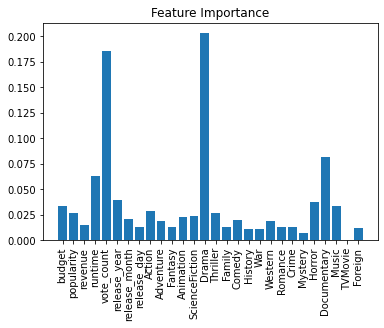

In [158]:
plt.bar(model.feature_names_in_, model.feature_importances_)
plt.xticks(rotation=90)
plt.title("Feature Importance")
plt.show()

Finally, we see the most important features in the XGBRegressor were `value_count`, `Drama`and `Documentary`. This goes to show that the genre of a film is pretty much determinant on how it will perform in terms of ratings.

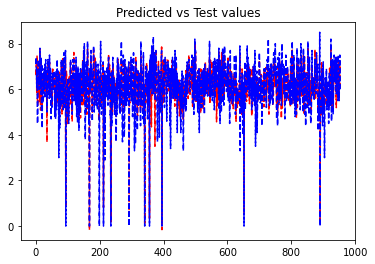

In [159]:
plt.plot(range(len(y_pred)), y_pred, "--", c="red")
plt.plot(range(len(y_pred)), y_test, "--", c="blue")
plt.title("Predicted vs Test values");

There is clearly a superposition of the values predicted with the ones tested. Let't take a further look on the error.

Text(0.5, 1.0, 'Mean Absolute Error')

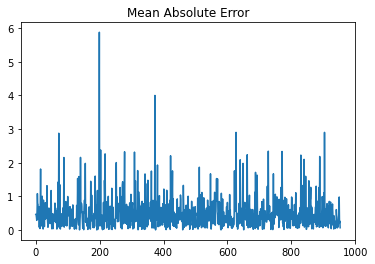

In [160]:
plt.plot(range(len(y_pred)), abs(y_pred - y_test))
plt.title("Mean Absolute Error")

From the previous plot and this one, we see that the biggest errors come from sudden 0 scores in the original dataset. Note that these are outliers. If we remove those, the Mean Absolute Error looks like:

In [161]:
y_test_no_0 = y_test[y_test != 0]
y_pred_no_0 = y_pred[y_test != 0]

mean_sq_error = mse(y_test_no_0, y_pred_no_0)
mean_abs_error = mae(y_test_no_0, y_pred_no_0)

print("Mean Squared Error: %.2f" % (mean_sq_error))
print("Mean Absolute Error: %.2f" % (mean_abs_error))

Mean Squared Error: 0.45
Mean Absolute Error: 0.49


Taking care of 0's in the test-set, MSE lowers to 0.47 and MAE stays 0.49.

# 8. Toy Example

In [162]:
import joblib

In [163]:
filename = "trained_xgb.joblib"
joblib.dump(model, filename)

['trained_xgb.joblib']

In order to use the model just use `joblib.load`

In [164]:
xgb_model = joblib.load("trained_xgb.joblib")

In [165]:
# make predictions for test data:
y_pred = model.predict(X_test)

mean_sq_error = mse(y_test, y_pred)
mean_abs_error = mae(y_test, y_pred)

print("Mean Squared Error: %.2f" % (mean_sq_error))
print("Mean Absolute Error: %.2f" % (mean_abs_error))

Mean Squared Error: 0.49
Mean Absolute Error: 0.49
